In [1]:
#from scipy.sparse.linalg import spsolve
#from scipy.sparse import csc_matrix
#import scipy.sparse as sparse
import scipy.linalg as linalg
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

In [61]:
def generateTriDiag(size, w):
    return np.diag(w*np.ones(size-1),-1) + np.diag(np.ones(size),0) + np.diag(w*np.ones(size-1),1)

def generateMat0(shuffle=False):
    Z = 1*np.eye(2*size) + np.triu(0.1*np.random.rand(2*size,2*size))
    if shuffle:
        Z = Z[:, np.random.permutation(Z.shape[1])]
        Z = Z + 2*np.eye(2*size)
    A = Z[:size,:size]
    B = Z[:size,size:] + 0.9*np.eye(size)
    Z[:size,size:] = B
    C = Z[size:,:size] + 0.4*np.eye(size)
    Z[size:,:size] = C
    D = Z[size:,size:]
    return A, B, C, D, Z

def generateMat1(w=0.1):
    A = generateTriDiag(size, w)
    B = np.eye(size)
    C = generateTriDiag(size, w)
    D = generateTriDiag(size, w)
    Z = np.zeros((2*size,2*size))
    Z[:size,:size] = A
    Z[:size,size:] = B
    Z[size:,:size] = C
    Z[size:,size:] = D
    return A, B, C, D, Z

########################################################

def method_stabL(nit, L):
    u = np.zeros(A.shape[0])
    v = np.zeros(A.shape[0])
    res = []
    for i in range(nit):
        v = linalg.solve(D + L*np.eye(A.shape[0]), f2 - np.dot(C, u) + L*v)
        u = linalg.solve(A, f1 - np.dot(B, v))
        #v = linalg.solve(D, f2 - C.dot(u))
        #u = linalg.solve(A + Lv*np.eye(A.shape[0]), f1 - np.dot(B,v) + Lv*v)
        res.append(np.linalg.norm(sol - np.concatenate((u,v))))
    return u, v, np.array(res)
    
def method_split(nit):
    AA = np.diag(A.diagonal(),0)
    invAA = np.diag(1/A.diagonal(),0)
    u = np.zeros(A.shape[0])
    v = np.zeros(A.shape[0])
    res = []
    for i in range(nit):
        M = D  - np.dot(C,np.dot(invAA,B))
        f = f2 - np.dot(C,np.dot(invAA,f1-np.dot(A-AA,u)))
        v = linalg.solve(M, f)
        u = linalg.solve(A, f1 - np.dot(B,v))
        res.append(np.linalg.norm(sol - np.concatenate((u,v))))
    return u, v, AA, invAA, np.array(res)

def method_split_stabL(nit, L):
    AA    = np.diag(A.diagonal(),0)
    invAA = np.diag(1/A.diagonal(),0)
    u = np.zeros(A.shape[0])
    v = np.zeros(A.shape[0])
    res = []
    for i in range(nit):
        M = D  - np.dot(C,np.dot(invAA,B)) + L*np.eye(A.shape[0])
        f = f2 - np.dot(C,np.dot(invAA,f1-np.dot(A-AA,u))) + L*v
        v = linalg.solve(M, f)
        u = linalg.solve(A, f1 - np.dot(B,v))
        res.append(np.linalg.norm(sol - np.concatenate((u,v))))
    return u, v, AA, invAA, np.array(res)

def method_gradsplit(nit, alpha):
    u = np.zeros(A.shape[0])
    v = np.zeros(A.shape[0])
    res = []
    AtA = np.dot(A.T,A)
    CtC = np.dot(C.T,C)
    AtB = np.dot(A.T,B)
    CtD = np.dot(C.T,D)
    BtA = np.dot(B.T,A)
    DtC = np.dot(D.T,C)
    BtB = np.dot(B.T,B)
    DtD = np.dot(D.T,D)
    for i in range(nit):
        u = u - alpha*2*(np.dot(AtA+CtC,u) + np.dot(AtB+CtD,v) - np.dot(A.T,f1) - np.dot(C.T,f2))
        v = v - alpha*2*(np.dot(BtA+DtC,u) + np.dot(BtB+DtD,v) - np.dot(B.T,f1) - np.dot(D.T,f2))
        res.append(np.linalg.norm(sol - np.concatenate((u,v))))
    return u, v, np.array(res)

def method_grad(nit, alpha):
    uv = np.zeros(2*size)
    res = []
    for i in range(nit):
        uv = uv - alpha*2*np.dot(Z.T,np.dot(Z,uv)-f)
        res.append(np.linalg.norm(sol - uv))
    return uv, np.array(res)

def method_quasiNewton(nit, alpha):
    u = np.zeros(A.shape[0])
    v = np.zeros(A.shape[0])
    res = []
    for i in range(nit):
        delta_u = linalg.solve(A, f1 - np.dot(A, u) - np.dot(B, v))
        u = u + alpha*delta_u
        delta_v = linalg.solve(D, f2 - np.dot(C, u) - np.dot(D, v))
        v = v + alpha*delta_v
        res.append(np.linalg.norm(sol - np.concatenate((u,v))))

    return u, v, np.array(res)

In [62]:
size = 20

A, B, C, D, Z = generateMat0(shuffle=False)
#A, B, C, D, Z = generateMat1()

f1 = np.random.rand(size)
f2 = np.random.rand(size)
print("determinant of Z =", linalg.det(Z))
print("condition number of Z =", np.linalg.cond(Z))

f = np.concatenate((f1,f2))
sol = linalg.solve(Z, f)
print(f"monolithic error = {np.linalg.norm(f-np.dot(Z,sol))}")

determinant of Z = 0.001720337404685524
condition number of Z = 9.071006450870804
monolithic error = 1.3164939779642846e-15


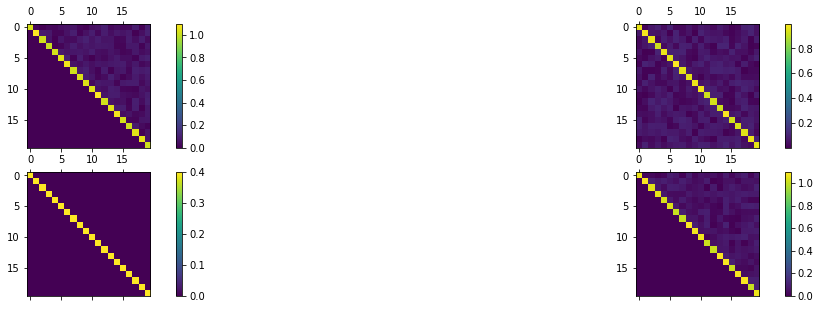

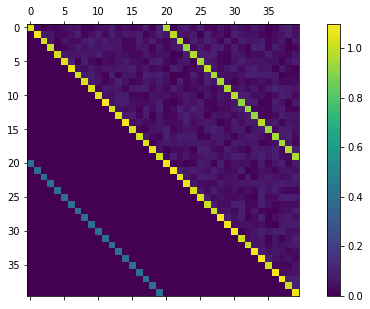

In [63]:
fig, axs = plt.subplots(2, 2, figsize=(20,5))
cax1 = axs[0,0].matshow(A)
cax2 = axs[0,1].matshow(B)
cax3 = axs[1,0].matshow(C)
cax4 = axs[1,1].matshow(D)
fig.colorbar(cax1, ax=axs[0,0])
fig.colorbar(cax2, ax=axs[0,1])
fig.colorbar(cax3, ax=axs[1,0])
fig.colorbar(cax4, ax=axs[1,1])

fig1, ax = plt.subplots(1, 1, figsize=(10,5))
cax = ax.matshow(Z)
fig.colorbar(cax, ax=ax)
plt.savefig('matrix.pdf')
plt.show()

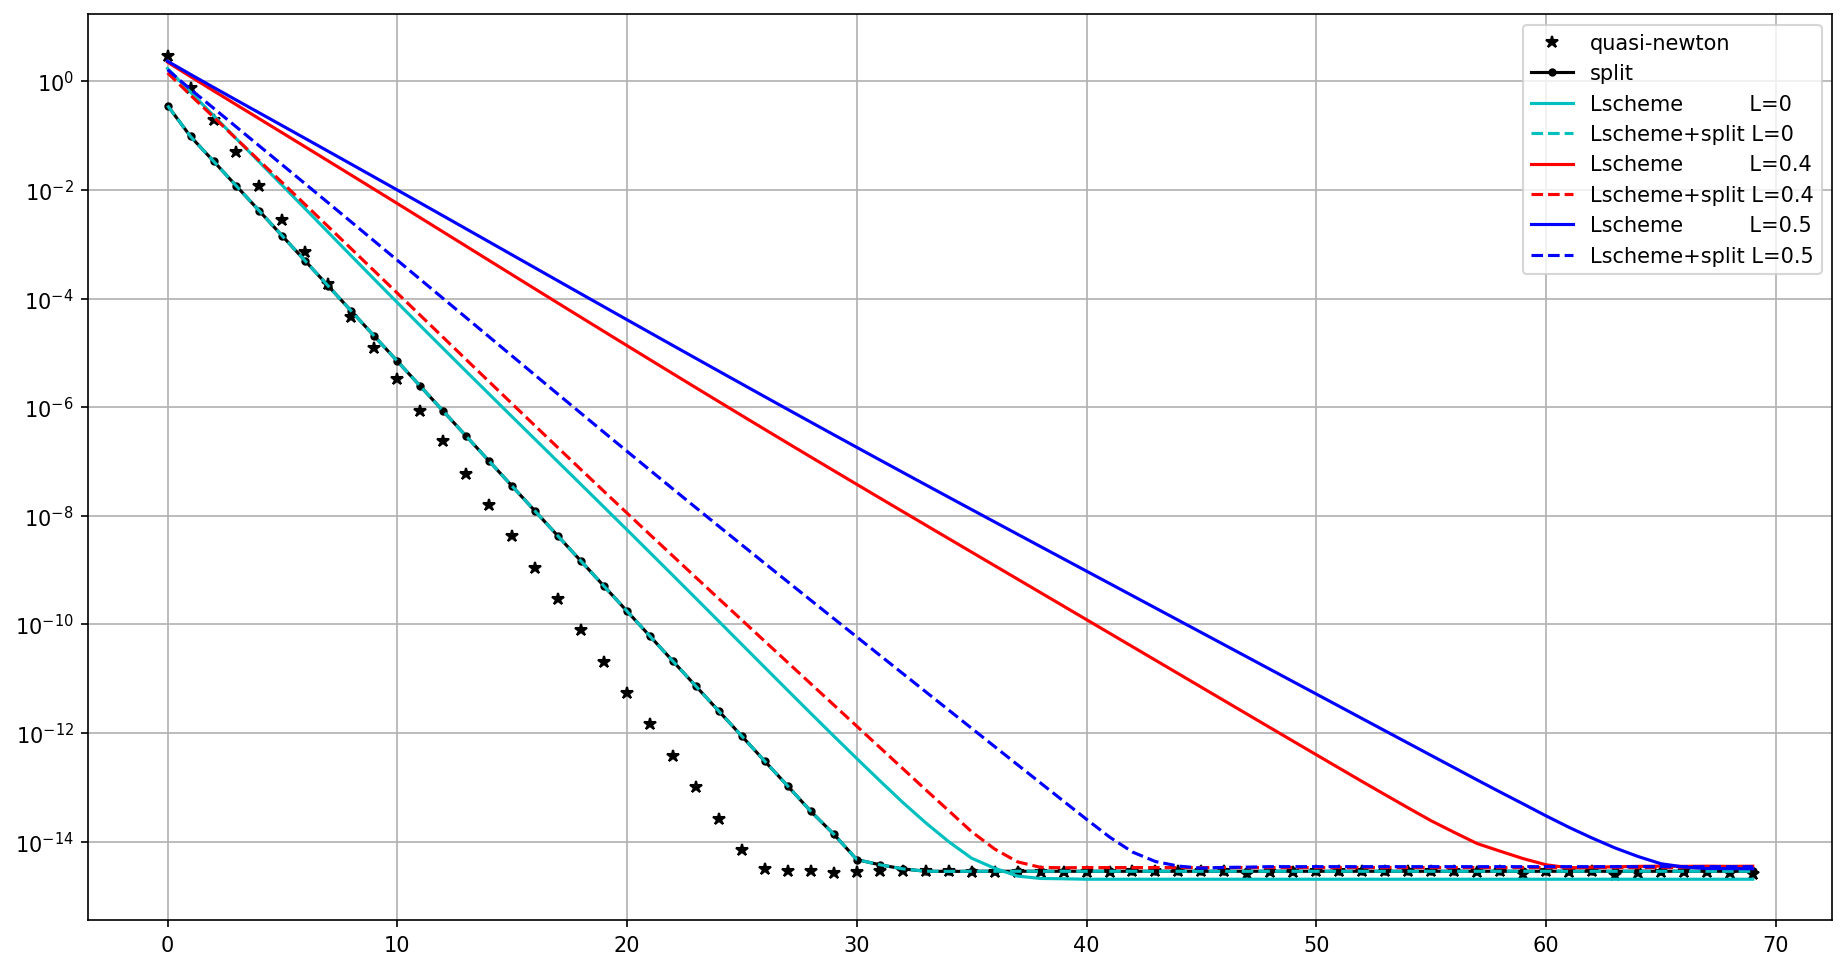

In [64]:
nit = 70
Lvec = [0.4, 0.5]
clrs = ['r', 'b', 'g']

plt.figure(dpi=150, figsize=(15,8))

u_newton, v_newton, res_newton = method_quasiNewton(nit, 1.1)
u_split, v_split, AA, invAA, res_split = method_split(nit)
u_stabL, v_stabL, res_stabL0 = method_stabL(nit, 0)
u_split_stabL, v_split_stabL, AA, invAA, res_split_stabL0 = method_split_stabL(nit, 0)

plt.semilogy(res_newton, 'k*', label="quasi-newton")
plt.semilogy(res_split, 'k.-', label="split")
plt.semilogy(res_stabL0, 'c-',        label=f"Lscheme          L={0}")
plt.semilogy(res_split_stabL0, 'c--', label=f"Lscheme+split L={0}")

for i, L in enumerate(Lvec):
    u_stabL, v_stabL, res_stabL = method_stabL(nit, L)
    u_split_stabL, v_split_stabL, AA, invAA, res_split_stabL = method_split_stabL(nit, L)
    plt.semilogy(res_stabL,       f'{clrs[i]}-',  label=f"Lscheme          L={L}")
    plt.semilogy(res_split_stabL, f'{clrs[i]}--', label=f"Lscheme+split L={L}")

plt.grid()
plt.legend()
plt.savefig('conv.pdf')
plt.show()